### Algorithme d'Optimisation par Colonie de Fourmis (ACO)

L'algorithme d'Optimisation par Colonie de Fourmis (ACO) est une méthode métaheuristique inspirée du comportement des fourmis dans leur recherche de nourriture. Ces insectes laissent derrière eux des phéromones lorsqu'ils trouvent de la nourriture, ce qui guide les autres membres de la colonie vers la source de nourriture.

Dans le problème du Bin Packing (BPP) ou le problème de "remplissage de sacs", l'objectif est de répartir un ensemble d'objets de différentes tailles dans un nombre minimal de sacs. L'ACO peut être appliqué à ce problème en considérant chaque sac comme une solution potentielle et en utilisant les phéromones pour guider la sélection des sacs lors du placement des objets.

### Utilisation de l'ACO pour Résoudre le Problème de Bin Packing

Dans le code fourni, nous implémentons l'algorithme ACO pour résoudre le problème BPP. Voici une vue d'ensemble des étapes clés :

1. **Génération des Solutions de Colonie :** Nous générons des solutions pour chaque fourmi en sélectionnant le sac approprié pour chaque objet en fonction des phéromones déposées et des capacités des sacs.

2. **Évaluation de la Fitness :** Nous évaluons la fitness de chaque solution en comptant le nombre de sacs uniques utilisés.

3. **Mise à jour des Pheromones :** Nous mettons à jour les phéromones en renforçant les chemins menant aux sacs qui ont été choisis pour les meilleures solutions.

4. **Évaporation des Pheromones :** Nous évaporons les phéromones pour éviter une convergence prématurée vers des solutions sous-optimales.

5. **Optimisation des Paramètres :** Nous effectuons des expériences en faisant varier le nombre de fourmis et le taux d'évaporation des phéromones pour trouver les paramètres optimaux qui minimisent le nombre de sacs utilisés et le temps d'exécution de l'algorithme.

À la fin de l'exécution, nous choisissons les paramètres qui donnent la solution optimale en termes de nombre de sacs utilisés et de temps d'exécution.

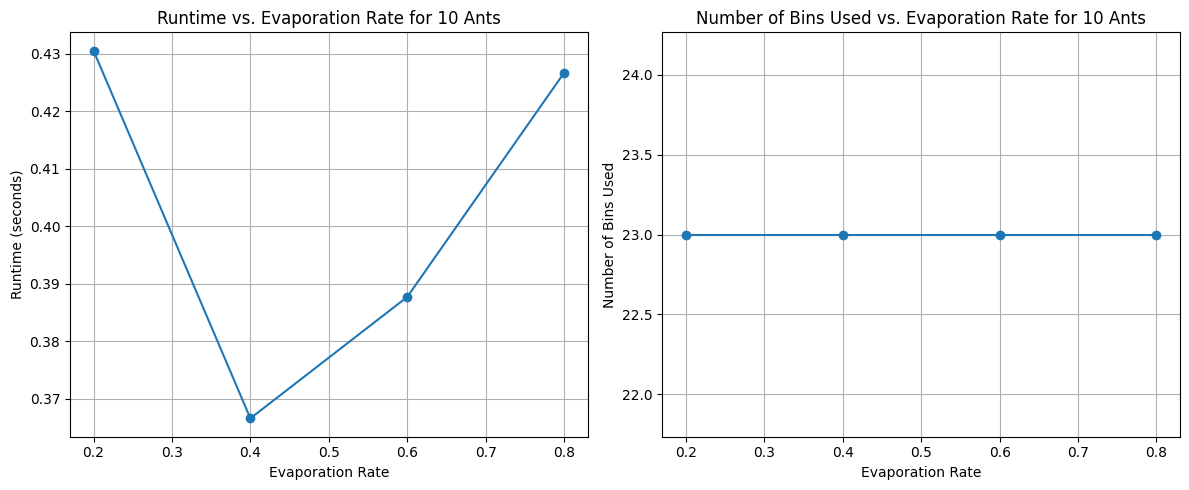

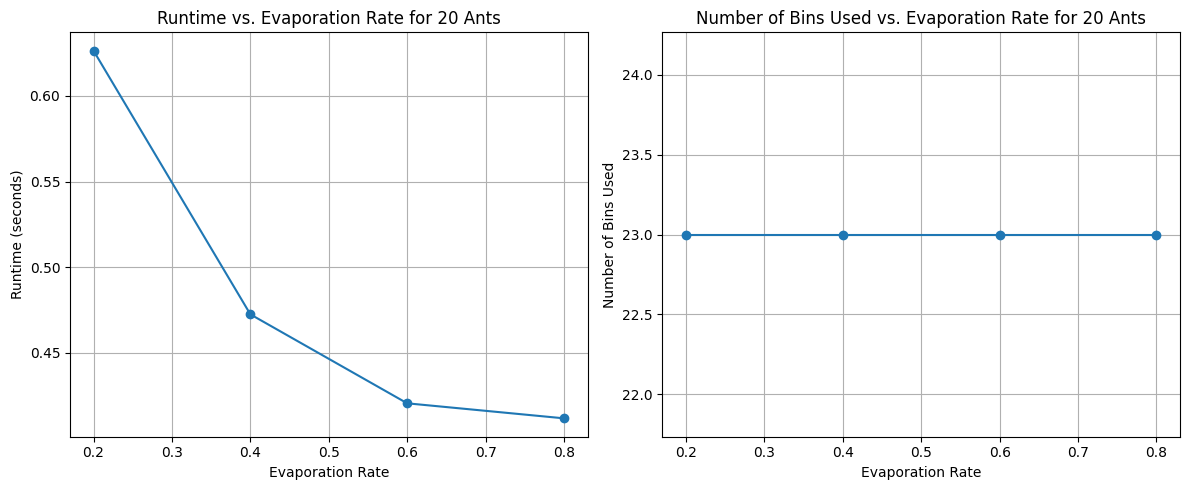

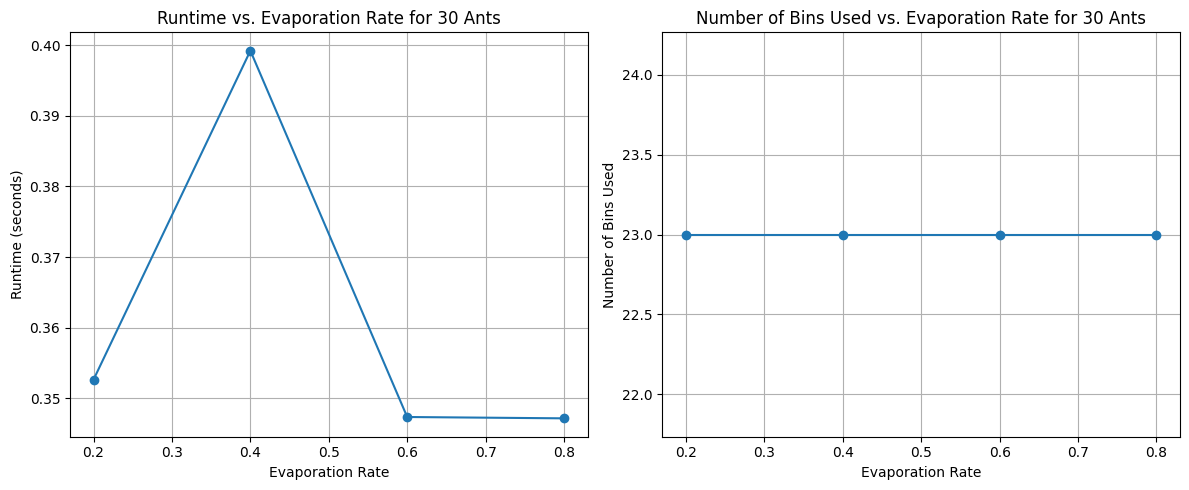

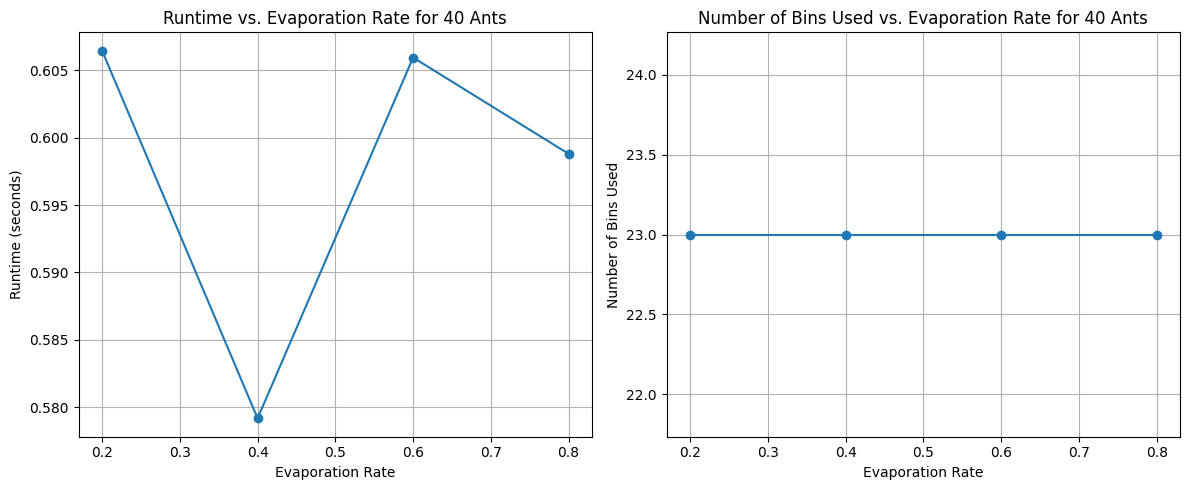

Best solution:
Number of Ants: 30
Evaporation Rate: 0.8
Number of Bins Used: 23
Runtime: 0.34719133377075195 seconds


In [1]:
import random
from numpy.random import choice
import numpy as np
import time

def GenerateColonySolutions(phermone_trail, num_items, num_ants, item_sizes , bin_capacity):
    # Initialize solutions and bin weights for each ant
    S = [[] for _ in range(num_ants)]
    bin_weights = [[] for _ in range(num_ants)]

    # Iterate over each ant
    for n in range(num_ants):
        # Iterate over each item
        for i in range(num_items):
            # Current number of bins
            b = len(bin_weights[n])
            # Extra space for potentially new bin
            probabilities = np.zeros(b + 1)
            # Random probability for opening a new bin
            probabilities[-1] = random.random()
            # Iterate over each existing bin
            for j in range(b):
                if bin_weights[n][j] + item_sizes[i] <= bin_capacity:
                    # Use existing pheromone trail
                    probabilities[j] = phermone_trail[j][0]
            # Normalize probabilities
            probabilities /= probabilities.sum()
            # Choose a bin based on probabilities
            chosen_bin = choice(range(len(probabilities)), p=probabilities)
            if chosen_bin == b:  # New bin
                # Add the item to the new bin
                bin_weights[n].append(item_sizes[i])
                S[n].append(chosen_bin)
                # Initialize pheromone for the new bin
                if (chosen_bin >= len(phermone_trail)):
                    phermone_trail.append([random.random()])
            else:
                # Add the item to an existing bin
                bin_weights[n][chosen_bin] += item_sizes[i]
                S[n].append(chosen_bin)

    return S, phermone_trail

def Fitness(S):
    # Calculate fitness (number of unique bins used) for each solution
    f = []
    for solution in S:
        f.append(len(set(solution)))
    return f

def ACO_BPP(num_ants, e, item_sizes, num_objects, bin_capacity):
    # Adjust iteration based on the number of ants
    iteration = int(200 / num_ants)
    # Start with an empty pheromone matrix
    pheromone_trail = []
    best_idx = 0 # Initialise the solotions
    best_fitness = len(item_sizes)

    # Run the ACO algorithm for a fixed number of iterations
    for itr in range(iteration):
        # Generate solutions for the current iteration
        S, pheromone_trail = GenerateColonySolutions(pheromone_trail, num_objects, num_ants, item_sizes, bin_capacity)
        # Evaluate fitness of the solutions
        f = Fitness(S)
        # Find the index of the best solution (minimum fitness)
        min_fitness = min(f)
        min_fitness_idx = f.index(min_fitness)

        # Update pheromones for better paths
        for bin_idx in S[min_fitness_idx]:
            pheromone_trail[bin_idx][0] += 100 / (min_fitness + 1)  # Increase pheromone

        # Pheromone evaporation
        for i in range(len(pheromone_trail)):
            pheromone_trail[i][0] *= e

        # Update the best fitness and index
        if min_fitness <= best_fitness:
            best_fitness = min_fitness
            best_idx = min_fitness_idx

    # Print the best solution and number of bins used
    #print(f"Solution: {S[best_idx]}")
    #print(f"Number of bins used: {best_fitness}")

    return best_fitness

# Read input parameters from file
item_sizes = []
bin_capacity = 0

filename = '/content/BPP_50_50_0.1_0.7_0.txt'
try:
    with open(filename, 'r') as file:
        # Read the first line to get the number of objects
        num_objects = int(file.readline().strip())
        # Read the second line to get the bin capacity
        bin_capacity = int(file.readline().strip())
        # Read the remaining lines, convert to integers where possible, and filter out non-digit lines
        item_sizes = [int(line.strip()) for line in file if line.strip().isdigit()]
except FileNotFoundError:
    print(f"Error: The file '{filename}' does not exist in the current directory.")
    exit()
except Exception as e:
    print(f"An error occurred: {e}")
    exit()

import matplotlib.pyplot as plt

# Définir les listes de tailles de colonies de fourmis et de taux d'évaporation à tester
num_ants_values = [10, 20, 30, 40]
evaporation_rates = [0.2, 0.4, 0.6, 0.8]

# Initialiser des listes pour stocker les résultats
best_solutions = {}  # Dictionary to store the best solutions for each combination of num_ants and evaporation_rate

# Boucles imbriquées pour tester toutes les combinaisons de paramètres
for num_ants in num_ants_values:
    runtimes = []
    num_bins_used = []
    for evaporation_rate in evaporation_rates:
        start_time = time.time()
        best_fitness = ACO_BPP(num_ants, evaporation_rate, item_sizes, num_objects, bin_capacity)
        end_time = time.time()
        runtime = end_time - start_time
        runtimes.append(runtime)
        num_bins_used.append(best_fitness)
        best_solutions[(num_ants, evaporation_rate)] = (runtime, best_fitness)

    # Plot the runtime vs. evaporation rate for each num_ants
    plt.figure(figsize=(12, 5))

    # Plot runtime vs. evaporation rate
    plt.subplot(1, 2, 1)
    plt.plot(evaporation_rates, runtimes, marker='o')
    plt.xlabel('Evaporation Rate')
    plt.ylabel('Runtime (seconds)')
    plt.title(f'Runtime vs. Evaporation Rate for {num_ants} Ants')
    plt.grid(True)

    # Plot number of bins used vs. evaporation rate
    plt.subplot(1, 2, 2)
    plt.plot(evaporation_rates, num_bins_used, marker='o')
    plt.xlabel('Evaporation Rate')
    plt.ylabel('Number of Bins Used')
    plt.title(f'Number of Bins Used vs. Evaporation Rate for {num_ants} Ants')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Find the best solution in terms of number of bins and runtime
best_solution_params = min(best_solutions, key=lambda x: (best_solutions[x][1], best_solutions[x][0]))
best_runtime, best_num_bins = best_solutions[best_solution_params]
best_num_ants, best_evaporation_rate = best_solution_params

print(f"Best solution:")
print(f"Number of Ants: {best_num_ants}")
print(f"Evaporation Rate: {best_evaporation_rate}")
print(f"Number of Bins Used: {best_num_bins}")
print(f"Runtime: {best_runtime} seconds")
